In [2]:
!conda env list

# conda environments:
#
base                     /home/liyin/anaconda3
pos                      /home/liyin/anaconda3/envs/pos
spacetime             *  /home/liyin/anaconda3/envs/spacetime



# SpaceTime 🌌⏱️ Demo - S&P 500 Price Forecasting + Trading

A quick demo and walkthrough of SpaceTime, using S&P 500 index prices as a sample dataset.  
* In Part 1, we'll walkthrough how to train SpaceTime models for forecasting, aiming to predict future S&P 500 index prices.  
* In Part 2, we'll create a simple trading bot using these forecasts. 

None of this is financial advice!

### Setup

In [3]:
# Install SpaceTime code
# !git clone https://github.com/HazyResearch/spacetime.git
!ls

spacetime  spacetime_demo_v2.ipynb


In [4]:
# General Setup
import os
import sys

from os.path import join

# Local imports from spacetime
project_dir = './spacetime'
sys.path.insert(0, os.path.abspath(project_dir)) 

In [5]:
# The data science trinity, we might not use all of them
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Installing dependencies - as a quick hack for colab we'll just convert the 
# environment.yaml into a requirements.txt, and use pip to install everything.
# Code below from https://gist.github.com/pemagrg1/f959c19ec18fee3ce2ff9b3b86b67c16
import yaml

with open(join(project_dir, 'environment.yaml')) as file_handle:
    environment_data = yaml.safe_load(file_handle)

requirements = []
for dep in environment_data['dependencies']:
    if isinstance(dep, str):
        try:
            package, package_version = dep.split('=')
            package_version = f'=={package_version}'
        except:
            package = dep
            package_version = ''
        if package not in ['python', 'pip', 'jupyter', 'jupyterlab',
                           'pytorch', 'pandas', 'numpy', 'matplotlib']:
            requirements.append(f'{package}{package_version}')
    elif isinstance(dep, dict):
        for preq in dep.get('pip', []):
            requirements.append(preq)

with open('requirements.txt', 'w') as fp:
    for requirement in requirements:
       print(requirement, file=fp)


In [60]:
# Install dependencies
#!pip install -r requirements.txt

## Part 1: Training to forecast with SpaceTime

We'll first download and setup some data via the Yahoo Finance API, showing how we can structure this data into a forecasting task and Pytorch dataloader for SpaceTime training. 

We'll then setup a SpaceTime model, walking through its configs and components. 

We'll finally train our SpaceTime model and visualize the results!

In [8]:
from omegaconf import OmegaConf

In [9]:
from utils.logging import print_config


In [10]:
# Hacky args via an OmegaConf config
args = """
seed: 42
"""
args = OmegaConf.create(args)
print_config(args)

CONFIG
└── seed
    └── 42                                                                                                         

### Part 1.1 Data + Task

#### Load and setup data

We'll start out with predicting closing prices for the S&P 500.

In [61]:
#!pip install yfinance #yahoo market data; finance api

In [12]:
import yfinance as yf

In [13]:
yf_data = yf.Ticker('^GSPC')  # Ticker for S&P 500

In [14]:
data = yf_data.history(period='max', start='1993-01-01',  # wow 30 years of data
                       auto_adjust=True)  

In [15]:

df = pd.DataFrame(data).reset_index()

In [16]:
# Visualize what we're dealing with, 30*365*5/7 ~= 7821
display(df.head(3))
display(df.tail(3))

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1993-01-04 00:00:00-05:00,435.700012,437.320007,434.480011,435.380005,201210000,0.0,0.0
1,1993-01-05 00:00:00-05:00,435.380005,435.399994,433.549988,434.339996,240350000,0.0,0.0
2,1993-01-06 00:00:00-05:00,434.339996,435.170013,432.519989,434.519989,295240000,0.0,0.0


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
7638,2023-05-03 00:00:00-04:00,4122.250000,4148.299805,4088.860107,4090.750000,4246510000,0.0,0.0
7639,2023-05-04 00:00:00-04:00,4082.550049,4082.610107,4048.280029,4061.219971,4920090000,0.0,0.0
7640,2023-05-05 00:00:00-04:00,4084.729980,4147.020020,4084.729980,4136.250000,4186270000,0.0,0.0


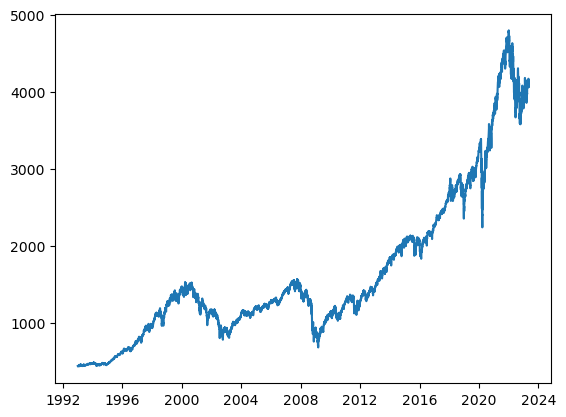

In [17]:
# Visualize closing prices
plt.plot(df['Date'], df['Close'])
plt.show()

#### Structure data 

We want a model that can forecast out a horizon of future terms given some past historical lag terms. To do so, we'll structure the data into a "sliding window" of sample inputs and targets `x, y`, where input `x` is a sequence of neighboring lag terms and target `y` is a sequence of neighboring horizon terms.

#### Set lag and horizon prediction task

In [18]:
args.lag = 84          # We'll use the prior 12 calendar weeks as inputs
args.horizon = 20      # We'll then try to predict out the next 20 available days (4ish working weeks)
args.target = 'Close'  # Pick one feature to forecast 

# Windows of samples
samples = [w.to_numpy() for w in df[args.target].rolling(window=args.lag + args.horizon)][args.lag + args.horizon - 1:]
# Dates for each sample
dates = [w for w in df['Date'].rolling(window=args.lag + args.horizon)][args.lag + args.horizon - 1:]

In [19]:
len(samples)  # Total number of samples

7538

In [20]:
dates[0]  # Double-check we're dealing with lag + horizon dates per sample

0     1993-01-04 00:00:00-05:00
1     1993-01-05 00:00:00-05:00
2     1993-01-06 00:00:00-05:00
3     1993-01-07 00:00:00-05:00
4     1993-01-08 00:00:00-05:00
                 ...           
99    1993-05-25 00:00:00-04:00
100   1993-05-26 00:00:00-04:00
101   1993-05-27 00:00:00-04:00
102   1993-05-28 00:00:00-04:00
103   1993-06-01 00:00:00-04:00
Name: Date, Length: 104, dtype: datetime64[ns, America/New_York]

#### Set evaluation timeframe
We'll see if we can predict market prices starting in 2022. To do so, we'll roughly construct a test set from the samples where the horizon terms start occurring in 2022 (note that for the first test samples, we'll then have some lag terms that occur in 2021).

We'll then create training and validation sets from the remaining data. 

In [21]:
import datetime

test_year = 2022  
test_date = datetime.date(test_year, 1, min(args.horizon, 30)) 

## Convert 'Date' to datetime object
df['Date'] = pd.to_datetime(df['Date']).dt.date

## Find indices corresponding to test year dates
test_ix = len(dates) - df[df['Date'] >= test_date].shape[0]

In [22]:
# Check that the horizon dates are roughly in 2022
dates[test_ix][args.lag:args.lag + args.horizon]

7297   2021-12-22 00:00:00-05:00
7298   2021-12-23 00:00:00-05:00
7299   2021-12-27 00:00:00-05:00
7300   2021-12-28 00:00:00-05:00
7301   2021-12-29 00:00:00-05:00
7302   2021-12-30 00:00:00-05:00
7303   2021-12-31 00:00:00-05:00
7304   2022-01-03 00:00:00-05:00
7305   2022-01-04 00:00:00-05:00
7306   2022-01-05 00:00:00-05:00
7307   2022-01-06 00:00:00-05:00
7308   2022-01-07 00:00:00-05:00
7309   2022-01-10 00:00:00-05:00
7310   2022-01-11 00:00:00-05:00
7311   2022-01-12 00:00:00-05:00
7312   2022-01-13 00:00:00-05:00
7313   2022-01-14 00:00:00-05:00
7314   2022-01-18 00:00:00-05:00
7315   2022-01-19 00:00:00-05:00
7316   2022-01-20 00:00:00-05:00
Name: Date, dtype: datetime64[ns, America/New_York]

#### Create training and validation splits

In [23]:
def train_val_split(data_indices, val_ratio=0.1):
    train_ratio = 1 - val_ratio
    last_train_index = int(np.round(len(data_indices) * train_ratio))
    return data_indices[:last_train_index], data_indices[last_train_index:]

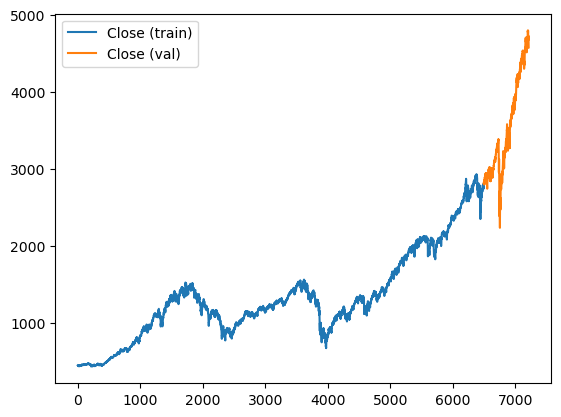

In [24]:
# Split data indices for train and val sets
train_indices, val_indices = train_val_split(np.arange(test_ix))
train_samples = np.array(samples[:val_indices[0]])
val_samples = np.array(samples[val_indices[0]:val_indices[-1]])

# Sanity check the splits by plotting the last horizon term in each sample
ix = -1
plt.plot(train_samples[:, ix], label=f'{args.target} (train)', alpha=1)
plt.plot(np.arange(len(train_samples), len(train_samples) + len(val_samples)), 
         val_samples[:, ix], label=f'{args.target} (val)', alpha=1)
plt.legend()
plt.show()

#### Capture the above in PyTorch datasets and dataloaders



In [25]:
import copy
import torch
from torch.utils.data import Dataset, DataLoader

In [26]:
class YahooStockPriceDataset(Dataset):
    def __init__(self, data: np.array, lag: int, horizon: int):
        super().__init__()
        self.data_x = torch.tensor(data).unsqueeze(-1).float()
        self.data_y = copy.deepcopy(self.data_x[:, -horizon:, :])
        
        self.lag = lag
        self.horizon = horizon
        
    def __len__(self):
        return len(self.data_x)
    
    def __getitem__(self, idx):
        x = self.data_x[idx]
        y = self.data_y[idx]
        x[-self.horizon:] = 0  # Mask input horizon terms
        return x, y, (self.lag, self.horizon)
    
    # For simplicity, we just keep these as identities.
    # But we could imagine some kind of data transformation / scaling for the inputs
    def transform(self, x):
        return x
    
    def inverse_transform(self, x):
        return x
        

In [27]:
# Function to load dataloaders for train, val, and test splits
def load_data(df: pd.DataFrame, 
              lag: int, 
              horizon: int, 
              target: str, 
              val_ratio: float,
              test_year_month_day: list[int], 
              **dataloader_kwargs: any):
    
    # Convert day-wise data into sequences of lag + horizon terms
    samples = [w.to_numpy() for w in df[target].rolling(window=lag + horizon)][lag + horizon - 1:]
    dates   = [w for w in df['Date'].rolling(window=lag + horizon)][lag + horizon - 1:]
    
    # Set aside test samples by date
    test_date = datetime.date(*test_year_month_day)
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    test_ix = len(dates) - df[df['Date'] >= test_date].shape[0]
    test_samples = np.array(samples[test_ix:])
    
    # Get training + validation samples
    train_indices, val_indices = train_val_split(np.arange(len(dates[:test_ix])), val_ratio)
    train_samples = np.array(samples[:val_indices[0]])
    val_samples = np.array(samples[val_indices[0]:val_indices[-1]])
    
    # PyTorch datasets and dataloaders
    datasets = [YahooStockPriceDataset(_samples, lag, horizon)
                for _samples in [train_samples, val_samples, test_samples]]
    
    dataloaders = [DataLoader(dataset, shuffle=True if ix == 0 else False, **dataloader_kwargs)
                   for ix, dataset in enumerate(datasets)]
    return dataloaders

In [28]:
# Function to visualize samples over time
def visualize_data(dataloaders, sample_idx, sample_dim=0,
                   splits=['train', 'val', 'test'], title=None):
    assert len(splits) == len(dataloaders)
    start_idx = 0
    for idx, split in enumerate(splits):
        y = dataloaders[idx].dataset.data_x[:, sample_idx, sample_dim]
        x = np.arange(len(y)) + start_idx
        plt.plot(x, y, label=split)
        start_idx += len(x)
    plt.title(title)
    plt.legend()
    plt.show()

#### Data + task setup via training configs

In [29]:
# Again we use OmegaConf bc it's great
dataset_configs = f"""
lag: {args.lag}
horizon: {args.horizon}
target: Close
val_ratio: 0.1
test_year_month_day:
- 2021
- 1
- 1
"""
dataset_configs = OmegaConf.create(dataset_configs)  

In [30]:
dataloader_configs = """
batch_size: 32
num_workers: 2
pin_memory: true
"""
dataloader_configs = OmegaConf.create(dataloader_configs)

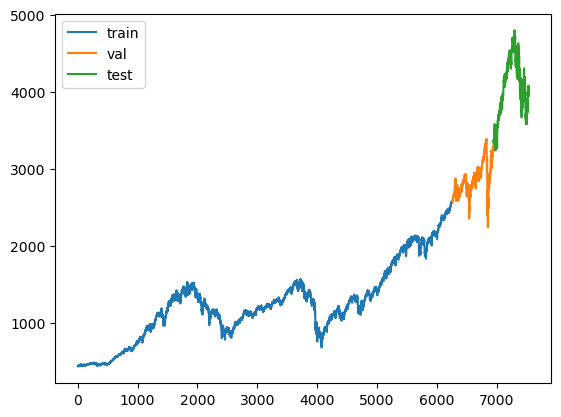

In [31]:
# Load and visualize data
torch.manual_seed(args.seed)
dataloaders = load_data(df, **dataset_configs, **dataloader_configs)
train_loader, val_loader, test_loader = dataloaders

visualize_data(dataloaders, sample_idx=0)


### Part 1.2 SpaceTime Model

We'll now define a SpaceTime model. To do so, we specify individual config files that determine individual components such as the input layer (*i.e.,* the embedding layer), the encoder layers, the decoder layer, and the final output layer.

We explicitly write out the configs below, but they can also be found as `.yaml` files in `spacetime/configs/model/` (see the `spacetime/README.md` for more details).

In [32]:
# We've got 4 main components to specify: 
# 1. The embedding / input projection (e.g., an MLP)
# 2. The encoder block ("open-loop" / convolutional SpaceTime SSMs go here)
# 3. The decoder block ("closed-loop" / recurrent SpaceTime SSMs go here)
# 4. The output projection (e.g., an MLP)

config_dir = 'spacetime/configs/'

In [33]:
embedding_config = """
method: repeat
kwargs:
  input_dim: 1
  embedding_dim: null
  n_heads: 4
  n_kernels: 32
"""
embedding_config = OmegaConf.create(embedding_config)

In [34]:
encoder_config = """
blocks:
- input_dim: 128
  pre_config: 'ssm/preprocess/residual'
  ssm_config: 'ssm/companion_preprocess'
  mlp_config: 'mlp/default'
  skip_connection: true
  skip_preprocess: false
"""
encoder_config = OmegaConf.create(encoder_config)

In [35]:
decoder_config = """
blocks:
- input_dim: 128
  pre_config: 'ssm/preprocess/none'
  ssm_config: 'ssm/closed_loop/companion'
  mlp_config: 'mlp/identity'
  skip_connection: false
  skip_preprocess: false
"""
decoder_config = OmegaConf.create(decoder_config)

In [36]:
output_config = """
input_dim: 128
output_dim: 1
method: mlp
kwargs:
  input_dim: 128
  output_dim: 1
  activation: gelu
  dropout: 0.2
  layernorm: false
  n_layers: 1
  n_activations: 1
  pre_activation: true
  input_shape: bld
  skip_connection: false
  average_pool: null
"""
output_config = OmegaConf.create(output_config)

#### Use configs to make a SpaceTime neural net

In [37]:
from model.network import SpaceTime
from setup import seed_everything

In [38]:
# Initialize SpaceTime encoder and decoder preprocessing, SSM, and MLP components
# - These are referenced as paths in the above encoder and decoder configs
def init_encoder_decoder_config(config, config_dir):
    for ix, _config in enumerate(config['blocks']):
        # Load preprocess kernel configs
        c_path = join(config_dir, f"{_config['pre_config']}.yaml")
        _config['pre_config'] = OmegaConf.load(c_path)
        # Load SSM kernel configs
        c_path = join(config_dir, f"{_config['ssm_config']}.yaml")
        _config['ssm_config'] = OmegaConf.load(c_path)
        # Load MLP configs
        c_path = join(config_dir, f"{_config['mlp_config']}.yaml")
        _config['mlp_config'] = OmegaConf.load(c_path)
    return config

In [39]:
encoder_config = init_encoder_decoder_config(encoder_config, join(config_dir, 'model'))
decoder_config = init_encoder_decoder_config(decoder_config, join(config_dir, 'model'))

In [40]:
# Initialize SpaceTime model
model_configs = {
    'embedding_config': embedding_config,
    'encoder_config': encoder_config,
    'decoder_config': decoder_config,
    'output_config': output_config,
    'lag': dataset_configs.lag,
    'horizon': dataset_configs.horizon
}
seed_everything(args.seed)

model = SpaceTime(**model_configs)

##### View architecture
We can either display the SpaceTime model as a PyTorch ``nn.Module`` object, or view the `OmegaConf` config behind it. 

In [41]:
from utils.config import print_config  # View OmegaConf configs

In [42]:
model  # PyTorch nn.Module view

SpaceTime(
  (embedding): RepeatEmbedding()
  (encoder): Encoder(
    (blocks): Sequential(
      (0): Block(
        (pre): ResidualSSM()
        (ssm): CompanionSSM()
        (mlp): MLP(
          (layernorm): Identity()
          (layers): Sequential(
            (0): GELU(approximate='none')
            (1): Dropout(p=0.2, inplace=False)
            (2): Linear(in_features=128, out_features=128, bias=True)
          )
        )
      )
    )
  )
  (decoder): Decoder(
    (blocks): ClosedLoopBlock(
      (pre): Identity()
      (ssm): ClosedLoopCompanionSSM()
      (mlp): Identity()
    )
  )
  (output): MLP(
    (layernorm): Identity()
    (layers): Sequential(
      (0): GELU(approximate='none')
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [43]:
print_config(model_configs)  # OmegaConf config view 
# (This might render as black text, not that useful here rip)

CONFIG
├── embedding_config
│   └── method: repeat                                                                                             
│       kwargs:                                                                                                    
│         input_dim: 1                                                                                             
│         embedding_dim: null                                                                                      
│         n_heads: 4                                                                                               
│         n_kernels: 32                                                                                            
│                                                                                                                  
├── encoder_config
│   └── blocks:                                                                                                    
│       - input_dim: 128                                                                                           
│         pre_config:                                                                                              
│           method: residual                                                                                       
│           kwargs:                                                                                                
│             max_diff_order: 4                                                                                    
│             min_avg_window: 4                                                                                    
│             max_avg_window: 64                                                                                   
│             model_dim: 128                                                                                       
│             n_kernels: 8                                                                                         
│             kernel_dim: 2                                                                                        
│             kernel_repeat: 16                                                                                    
│             n_heads: 1                                                                                           
│             head_dim: 1                                                                                          
│             kernel_weights: null                                                                                 
│             kernel_init: null                                                                                    
│             kernel_train: false                                                                                  
│             skip_connection: false                                                                               
│         ssm_config:                                                                                              
│           method: companion                                                                                      
│           kwargs:                                                                                                
│             model_dim: 128                                                                                       
│             n_kernels: 16                                                                                        
│             kernel_dim: 64                                                                                       
│             kernel_repeat: 1                                                                                     
│             n_heads: 8                                                                                           
│             head_dim: 1                                                                                          
│        

### Part 1.3 SpaceTime Model Training

We'll now specify the training configs and train our model

In [44]:
from loss import get_loss
from data_transforms import get_data_transforms
from optimizer import get_optimizer, get_scheduler
from setup.configs.optimizer import get_optimizer_config, get_scheduler_config

from train import train_model, evaluate_model, plot_forecasts

#### Specify training args

In [45]:
# Hacky training args, see the README or /spacetime/setup/args.py for details
arg_config = f"""
lag: {dataset_configs.lag}
horizon: {dataset_configs.horizon}
features: S
lr: 1e-3
weight_decay: 1e-4
dropout: 0.25
criterion_weights:
- 10
- 1
- 10
optimizer: adamw
scheduler: timm_cosine
max_epochs: 500
early_stopping_epochs: 20
data_transform: mean
loss: informer_rmse
val_metric: informer_rmse
seed: 42
dataset: sp500
variant: null
model: SpaceTime
"""
class Args():
    def __init__(self, args):
        for k, v in args.items():
            setattr(self, k, v)
            
args = Args(OmegaConf.create(arg_config))
# GPU
args.device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')

# These others are not super important
args.checkpoint_dir = './checkpoints'
args.log_dir = './log_dir'
args.variant = None
args.no_wandb = True
args.dataset_type = 'informer'  # for standard forecasting
args.log_epoch = 1000

In [46]:
args.criterion_weights

[10, 1, 10]

#### Initialize optimizer, scheduler, criterions, data transforms

In [47]:
seed_everything(args.seed)
model = SpaceTime(**model_configs)  # Reset model from here

model.set_lag(args.lag)
model.set_horizon(args.horizon)
    
# Initialize optimizer and scheduler
optimizer = get_optimizer(model, get_optimizer_config(args, config_dir))
scheduler = get_scheduler(model, optimizer, get_scheduler_config(args, config_dir))
    
# Loss objectives
criterions = {name: get_loss(name) for name in ['rmse', 'mse', 'mae']}
eval_criterions = criterions
for name in ['rmse', 'mse', 'mae']:
    eval_criterions[f'informer_{name}'] = get_loss(f'informer_{name}')
    
# Data transforms, e.g., normalization
input_transform, output_transform = get_data_transforms(args.data_transform, args.lag)

/home/liyin/anaconda3/envs/spacetime/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/liyin/anaconda3/envs/spacetime/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops10select_int4callERKNS_6TensorEll
  warn(f"Failed to load image Python extension: {e}")


#### Train model

In [48]:
from setup import initialize_experiment

In [49]:
initialize_experiment(args, experiment_name_id='',
                      best_train_metric=1e10, 
                      best_val_metric=1e10)

-> Created model checkpoint saving directory at ./checkpoints/sp500!
-> Created logging directory at ./log_dir/spacetime-d=sp500-f=S-horizon=20!


In [50]:
# Actually train model
splits = ['train', 'val', 'test']
dataloaders_by_split = {split: dataloaders[ix] 
                        for ix, split in enumerate(splits)}

model = train_model(model, optimizer, scheduler, dataloaders_by_split, 
                    criterions, max_epochs=args.max_epochs, config=args, 
                    input_transform=input_transform,
                    output_transform=output_transform,
                    val_metric=args.val_metric, wandb=None, 
                    return_best=True, early_stopping_epochs=args.early_stopping_epochs) 

  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping at epoch 32...
-> Saved best val model checkpoint at epoch 12!
   - Saved to: ./checkpoints/sp500/bval-m=SpaceTime-la=84-ho=20-fe=S-dt=mean-cw=1+1+1-lo=ir-dr=0.25-lr=0.001-op=adamw-sc=tc-wd=0.0001-vm=ir-me=500-ese=20-se=42.pth
-> Saved best train model checkpoint at epoch 32!
   - Saved to: ./checkpoints/sp500/btrn-m=SpaceTime-la=84-ho=20-fe=S-dt=mean-cw=1+1+1-lo=ir-dr=0.25-lr=0.001-op=adamw-sc=tc-wd=0.0001-vm=ir-me=500-ese=20-se=42.pth
Returning best val model from epoch 12


In [68]:
type(args), vars(args)

(__main__.Args,
 {'lag': 84,
  'horizon': 20,
  'features': 'S',
  'lr': 0.001,
  'weight_decay': 0.0001,
  'dropout': 0.25,
  'criterion_weights': [1.0, 1.0, 1.0],
  'optimizer': 'adamw',
  'scheduler': 'timm_cosine',
  'max_epochs': 500,
  'early_stopping_epochs': 20,
  'data_transform': 'mean',
  'loss': 'informer_rmse',
  'val_metric': 'informer_rmse',
  'seed': 42,
  'dataset': 'sp500',
  'variant': None,
  'model': 'SpaceTime',
  'device': device(type='cuda', index=0),
  'checkpoint_dir': './checkpoints/sp500',
  'log_dir': './log_dir/spacetime-d=sp500-f=S-horizon=20',
  'no_wandb': True,
  'dataset_type': 'informer',
  'log_epoch': 1000,
  'experiment_name': 'm=SpaceTime-la=84-ho=20-fe=S-dt=mean-cw=1+1+1-lo=ir-dr=0.25-lr=0.001-op=adamw-sc=tc-wd=0.0001-vm=ir-me=500-ese=20-se=42',
  'dataset_name': 'sp500',
  'best_train_metric': 31.996358949310924,
  'best_val_metric': 110.00762471285734,
  'best_train_checkpoint_path': './checkpoints/sp500/btrn-m=SpaceTime-la=84-ho=20-fe=S-dt=me

### Evaluate model

In [51]:
from dataloaders import get_evaluation_loaders
from train.evaluate import plot_forecasts

-----------------------------------------
Best validation model: eval_train metrics
-----------------------------------------
- total: 125080.0
- rmse: 1.6291484145947375
- mse: 1624.717153853565
- mae: 28.12534988740019
- informer_rmse: 34.505844563853984
- informer_mse: 1628.2766604520837
- informer_mae: 28.152695627845063
----------------------------------
Best validation model: val metrics
----------------------------------
- total: 13880.0
- rmse: 5.130350918728611
- mse: 21076.126819164267
- mae: 89.03875257508555
- informer_rmse: 110.00762471285734
- informer_mse: 20975.22920920632
- informer_mae: 89.08281508359042
-----------------------------------
Best validation model: test metrics
-----------------------------------
- total: 11780.0
- rmse: 7.1360544926849006
- mse: 27953.131218166385
- mae: 125.22261745278014
- informer_rmse: 149.85619936491312
- informer_mse: 27586.590871710527
- informer_mae: 124.9058767619886


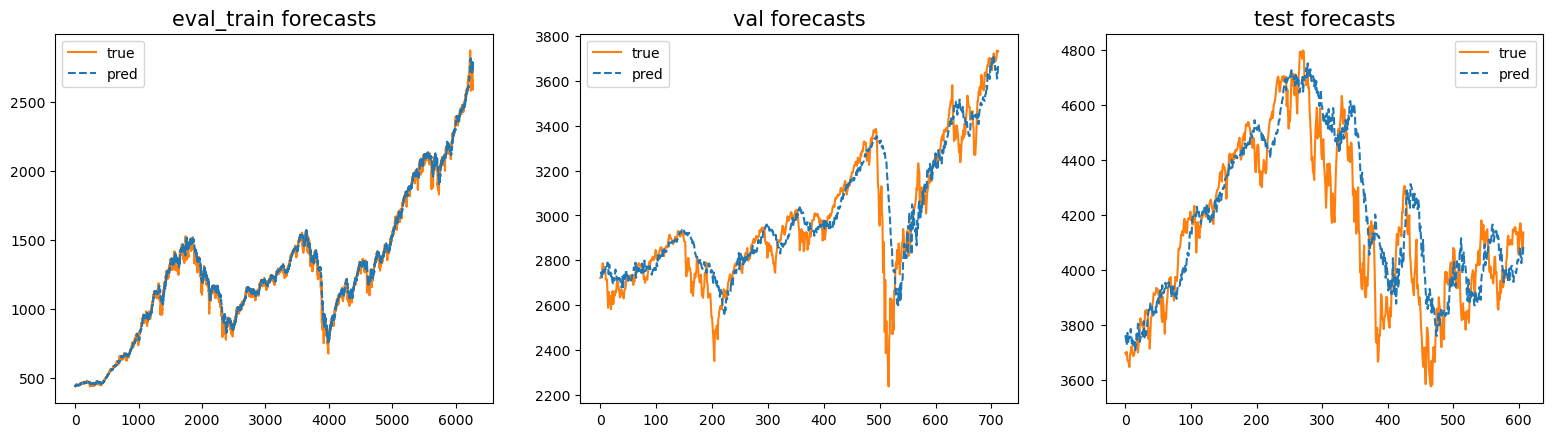

In [52]:
eval_splits = ['eval_train', 'val', 'test']
eval_loaders = get_evaluation_loaders(dataloaders, batch_size=dataloader_configs.batch_size)
eval_loaders_by_split = {split: eval_loaders[ix] for ix, split in
                         enumerate(eval_splits)}
model, log_metrics, total_y = evaluate_model(model, dataloaders=eval_loaders_by_split, 
                                             optimizer=optimizer, scheduler=scheduler, 
                                             criterions=eval_criterions, config=args,
                                             epoch=args.best_val_metric_epoch, 
                                             input_transform=input_transform, 
                                             output_transform=output_transform,
                                             val_metric=args.val_metric, wandb=None,
                                             train=False)
n_plots = len(splits) # train, val, test
fig, axes = plt.subplots(1, n_plots, figsize=(6.4 * n_plots, 4.8))

plot_forecasts(total_y, splits=eval_splits, axes=axes)

-----------------------------------------
Best validation model: eval_train metrics
-----------------------------------------
- total: 125080.0
- rmse: 1.6291484145947375
- mse: 1624.717153853565
- mae: 28.12534988740019
- informer_rmse: 34.505844563853984
- informer_mse: 1628.2766604520837
- informer_mae: 28.152695627845063
----------------------------------
Best validation model: val metrics
----------------------------------
- total: 13880.0
- rmse: 5.130350918728611
- mse: 21076.126819164267
- mae: 89.03875257508555
- informer_rmse: 110.00762471285734
- informer_mse: 20975.22920920632
- informer_mae: 89.08281508359042
-----------------------------------
Best validation model: test metrics
-----------------------------------
- total: 11780.0
- rmse: 7.1360544926849006
- mse: 27953.131218166385
- mae: 125.22261745278014
- informer_rmse: 149.85619936491312
- informer_mse: 27586.590871710527
- informer_mae: 124.9058767619886


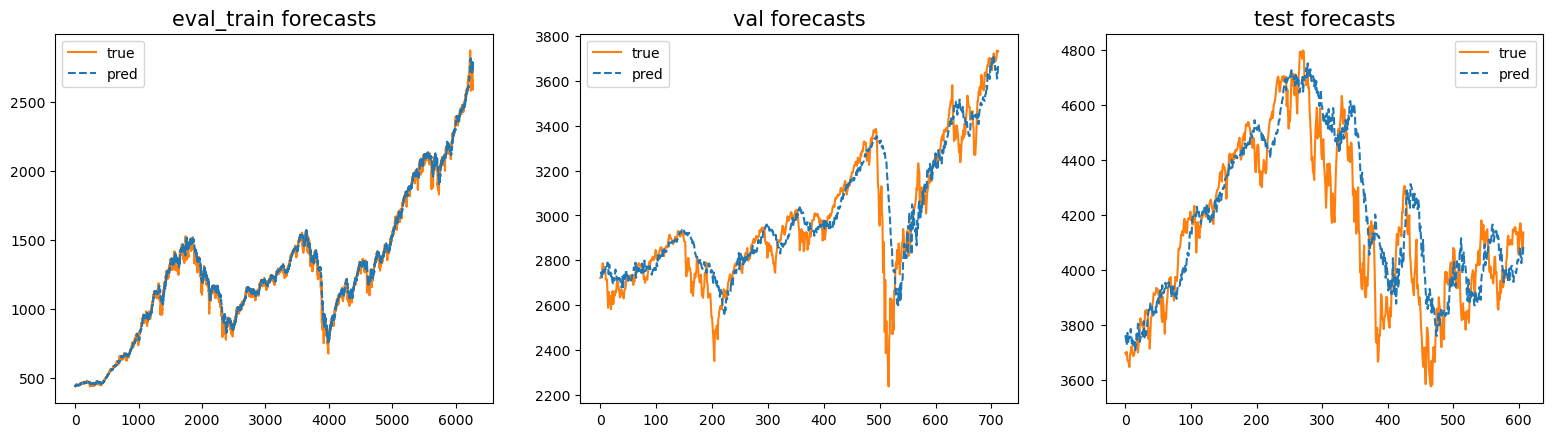

In [53]:
eval_splits = ['eval_train', 'val', 'test']
eval_loaders = get_evaluation_loaders(dataloaders, batch_size=dataloader_configs.batch_size)
eval_loaders_by_split = {split: eval_loaders[ix] for ix, split in
                         enumerate(eval_splits)}
model, log_metrics, total_y = evaluate_model(model, dataloaders=eval_loaders_by_split, 
                                             optimizer=optimizer, scheduler=scheduler, 
                                             criterions=eval_criterions, config=args,
                                             epoch=args.best_val_metric_epoch, 
                                             input_transform=input_transform, 
                                             output_transform=output_transform,
                                             val_metric=args.val_metric, wandb=None,
                                             train=False)
n_plots = len(splits) # train, val, test
fig, axes = plt.subplots(1, n_plots, figsize=(6.4 * n_plots, 4.8))

plot_forecasts(total_y, splits=eval_splits, axes=axes)